In [1]:
from get_convertor import cifar10_convert as convert
import os
import json
import chainer
from chainer import serializers
import pickle
from tqdm import tqdm

import random
import numpy as np
from cnn import CNN

import general_model
general_model.is_print = False

saved_dir = '../results/models/cifar10_cnn'
gpu = 0

with open(os.path.join(saved_dir, 'encoded_data.pkl'), 'rb') as fi:
    all_data = pickle.load(fi)
train, dev, test = all_data['train'], all_data['dev'], all_data['test']
with open(os.path.join(saved_dir, 'setting.json')) as fi:
    setting = json.load(fi)
model_file = os.path.join(saved_dir, 'best_model.npz')

out_channels = [int(n) for n in setting['out_dims'].split(' ')]
ksizes = [int(n) for n in setting['filter_sizes'].split(' ')]
pool_sizes = [int(n) for n in setting['pool_sizes'].split(' ')]

model = CNN(
        input_channel=3,
        out_channels=out_channels,
        ksizes=ksizes,
        pool_sizes=pool_sizes,
        num_classes=10,
        dropout=0,
        out_dir=saved_dir
    )

if gpu > -1:
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

serializers.load_npz(model_file, model)

In [2]:
def cossim(a, b):
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    if denom > 0:
        return np.dot(a, b) / denom
    else:
        return 0
    
def l2sim(a, b):
    return -np.linalg.norm(a - b)

In [3]:
import matplotlib.pyplot as plt

def show_data_1(data, label=None):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    x = data[0]
    y = data[1]
    ax.imshow(x.transpose(1, 2, 0), interpolation='none')
    ax.axis('off')
    if label is not None:
        ax.set_title(label, fontsize=10)
    plt.tight_layout()
    plt.show()
    
def show_data_k(datas, labels=None):
    fig, ax = plt.subplots(1, len(datas), figsize=(2 * len(datas), 2))
    for i, data in enumerate(datas):
        x = data[0]
        y = data[1]
        ax[i].imshow(x.transpose(1, 2, 0), interpolation='none')
        ax[i].axis('off')
        if labels is not None:
            ax[i].set_title(labels[i], fontsize=10)
    plt.tight_layout()
    plt.show()

## Figure 1

test input


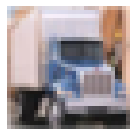

relevance instance


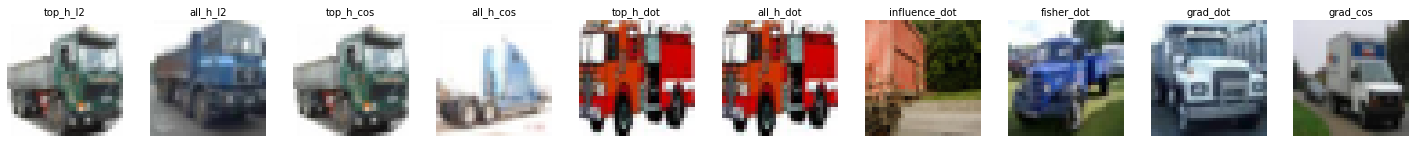

In [4]:
test_idx = 2789
target_data = test[test_idx]
import metrics
met_names = ['top_h_l2', 'all_h_l2', 'top_h_cos', 'all_h_cos', 'top_h_dot', 'all_h_dot', 'influence_dot', 'fisher_dot', 'grad_dot', 'grad_cos']
met_dic = {n: f for n, f in zip(metrics.met_names, metrics.met_funcs)}
ret_data = []
for met in met_names:
    scores = met_dic[met](target_data, train, model, convert)
    top_idx = np.argmax(scores)
    ret_data.append(train[top_idx])
print('test input')
show_data_1(target_data)
print('relevance instance')
show_data_k(ret_data, met_names)

## Figure 4

In [4]:
train_grads = np.load(os.path.join(saved_dir, 'train-grad-on-loss-all.npy'))
grad_norms = np.linalg.norm(train_grads, axis=1)
train_grads_hess = np.load(os.path.join(saved_dir, 'train-grad-on-loss-all_inv_sqrt_hessian.npy'))
hess_grad_norms = np.linalg.norm(train_grads_hess, axis=1)
train_grads_fisher = np.load(os.path.join(saved_dir, 'train-grad-on-loss-all_inv_sqrt_fisher.npy'))
fisher_grad_norms = np.linalg.norm(train_grads_fisher, axis=1)

In [28]:
import pickle
from collections import defaultdict
met_names = [
             'influence_dot',
             'fisher_dot',
             'grad_dot',
            'grad_cos',
             ]

counter_dupl = defaultdict(lambda: defaultdict(list))
result_file = '../results/all_scores/identical_class_test/score_cifar10_cnn.0.pkl'
with open(result_file, 'rb') as fi:
    all_results = pickle.load(fi)
results = all_results['results']
for res in results:
    scores = res['scores']
    top_idx = np.argmax(scores)
    counter_dupl[res['met']][top_idx].append((res['idx'], scores[top_idx]))

In [46]:
selecting_idxs = {}
for met in met_names:
    res = []
    for i in range(len(train_grads)):
        if met.startswith('grad_'):
            norms = grad_norms
        elif met.startswith('influence_'):
            norms = hess_grad_norms
        elif met.startswith('fisher_'):
            norms = fisher_grad_norms
        dupl = counter_dupl[met][i]
        norm = norms[i]
        res.append((i, dupl, norm))
    srt_res = sorted(res, key=lambda x: -len(x[1]))
    selecting_idxs[met] = srt_res

### (a) IF

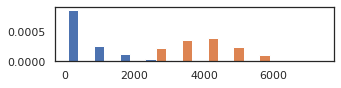

In [49]:
norms_sel = []
for d in selecting_idxs['influence_dot']:
    for _ in range(len(d[1])):
        norms_sel.append(d[2])
norms_sel = np.array(norms_sel)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style='white') 

plt.figure(figsize=(5, 1))
plt.hist([hess_grad_norms, norms_sel], bins=10, density=True)
plt.show()

### (b) FK

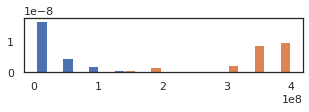

In [31]:
norms_sel = []
for d in selecting_idxs['fisher_dot']:
    for _ in range(len(d[1])):
        norms_sel.append(d[2])
norms_sel = np.array(norms_sel)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style='white') 

plt.figure(figsize=(5, 1))
plt.hist([fisher_grad_norms, norms_sel], bins=10, density=True)
plt.show()

### (c) GD

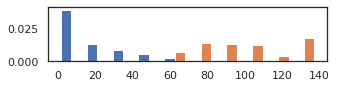

In [32]:
norms_sel = []
for d in selecting_idxs['grad_dot']:
    for _ in range(len(d[1])):
        norms_sel.append(d[2])
norms_sel = np.array(norms_sel)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style='white') 

plt.figure(figsize=(5, 1))
plt.hist([grad_norms, norms_sel], bins=10, density=True)
plt.show()

### (d) GC

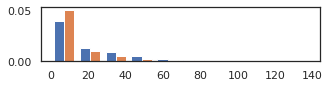

In [33]:
norms_sel = []
for d in selecting_idxs['grad_cos']:
    for _ in range(len(d[1])):
        norms_sel.append(d[2])
norms_sel = np.array(norms_sel)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style='white') 

plt.figure(figsize=(5, 1))
plt.hist([grad_norms, norms_sel], bins=10, density=True)
plt.show()

## Figure 5

### (a) IF

--- train data ---
truck
3585.0602653968813


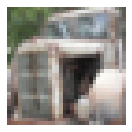

--- test data ---
7.520759330603421e-05
0.00010033743644424549
7.098021826410788e-05


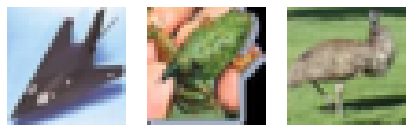

In [106]:
trainidx_selecting_norm = selecting_idxs['influence_dot'][3]
train_idx = trainidx_selecting_norm[0]
train_norm = trainidx_selecting_norm[2]
train_data = train[train_idx]
print('--- train data ---')
print(class_names[train_data[1]])
print(train_norm)
show_data_1(train_data)

coss = []
datas = []
test_is = [0, 1, 2]
srt = list(sorted(trainidx_selecting_norm[1], key=lambda x: -x[1]))
for test_i in test_is:
    idx = srt[test_i]
    test_idx = idx[0]
    test_data = test[test_idx]
    cos_scores = model.get_relevance_by_grad(test_data,
                                            train,
                                            convert,
                                            force_refresh=False,
                                            matrix='inv-hessian',
                                            sim_func=cossim)
    cos = cos_scores[train_idx]
    coss.append(cos)
    datas.append(test_data)
print('--- test data ---')
for cos in coss:
    print(cos)
show_data_k(datas)

### (b) FK

--- train data ---
ship
345292727.4536769


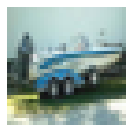

--- test data ---
0.021738323739874915
0.020340995761106023
0.01972618868602537


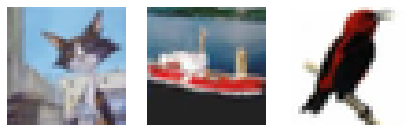

In [102]:
trainidx_selecting_norm = selecting_idxs['fisher_dot'][2]
train_idx = trainidx_selecting_norm[0]
train_norm = trainidx_selecting_norm[2]
train_data = train[train_idx]
print('--- train data ---')
print(class_names[train_data[1]])
print(train_norm)
show_data_1(train_data)

coss = []
datas = []
test_is = [0, 1, 2]
srt = list(sorted(trainidx_selecting_norm[1], key=lambda x: -x[1]))
for test_i in test_is:
    idx = srt[test_i]
    test_idx = idx[0]
    test_data = test[test_idx]
    cos_scores = model.get_relevance_by_grad(test_data,
                                            train,
                                            convert,
                                            force_refresh=False,
                                            matrix='inv-fisher',
                                            sim_func=cossim)
    cos = cos_scores[train_idx]
    coss.append(cos)
    datas.append(test_data)
print('--- test data ---')
for cos in coss:
    print(cos)
show_data_3(datas)


### (c) GD

--- train data ---
truck
112.792984


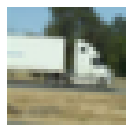

--- test data ---
0.38541440665689863
0.29132427218074436
0.3291862124000894


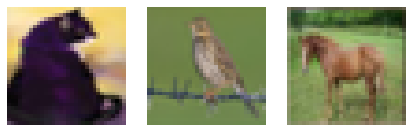

In [103]:
trainidx_selecting_norm = selecting_idxs['grad_dot'][4]
train_idx = trainidx_selecting_norm[0]
train_norm = trainidx_selecting_norm[2]
train_data = train[train_idx]
print('--- train data ---')
print(class_names[train_data[1]])
print(train_norm)
show_data_1(train_data)

coss = []
datas = []
test_is = [0, 3, 4]
srt = list(sorted(trainidx_selecting_norm[1], key=lambda x: -x[1]))
for test_i in test_is:
    idx = srt[test_i]
    test_idx = idx[0]
    test_data = test[test_idx]
    cos_scores = model.get_relevance_by_grad(test_data,
                                            train,
                                            convert,
                                            force_refresh=False,
                                            matrix='none',
                                            sim_func=cossim)
    cos = cos_scores[train_idx]
    coss.append(cos)
    datas.append(test_data)
print('--- test data ---')
for cos in coss:
    print(cos)
show_data_3(datas)


### (d) GC

--- train data ---
truck
0.0008031349


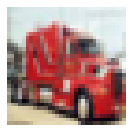

--- test data ---
0.7541077993208875
0.7536436247319744
0.752403223882555


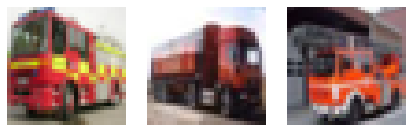

In [104]:
trainidx_selecting_norm = selecting_idxs['grad_cos'][1]
train_idx = trainidx_selecting_norm[0]
train_norm = trainidx_selecting_norm[2]
train_data = train[train_idx]
print('--- train data ---')
print(class_names[train_data[1]])
print(train_norm)
show_data_1(train_data)

coss = []
datas = []
test_is = [0, 1, 2]
srt = list(sorted(trainidx_selecting_norm[1], key=lambda x: -x[1]))
for test_i in test_is:
    idx = srt[test_i]
    test_idx = idx[0]
    test_data = test[test_idx]
    cos_scores = model.get_relevance_by_grad(test_data,
                                            train,
                                            convert,
                                            force_refresh=False,
                                            matrix='none',
                                            sim_func=cossim)
    cos = cos_scores[train_idx]
    coss.append(cos)
    datas.append(test_data)
print('--- test data ---')
for cos in coss:
    print(cos)
show_data_3(datas)

## Figure 6

In [16]:
model.convertor = convert
def get_grad_output(test_data):
    *inputs, y = model.convertor([test_data], model.device)
    preds = model.predict(*inputs, softmax=False)[0]
    grads = []
    for p in preds:
        model.cleargrads()
        p.backward()
        grad = model.get_flat_param_grad()
        grads.append(chainer.cuda.to_cpu(grad.data))
    return np.vstack(grads)

from random import choice
grad_sims_same = []
grad_sims_not_same = []
res_sims_same = []
res_sims_not_same = []
for d_test in test[:500]:
    test_grad = model.get_grad_loss(d_test)
    test_x = model.get_x(*model.convertor([d_test], model.device))[0]
    x, y = convert([d_test], model.device)
    pred_dist = chainer.cuda.to_cpu(model.predict(x, argmax=False).data)
    test_pred = (pred_dist - np.eye(10)[chainer.cuda.to_cpu(y)])[0]

    while True:
        d_train = choice(train)
        if int(d_train[1]) == int(d_test[1]):
            break

    train_grad = model.get_grad_loss(d_train)
    grad_sims_same.append(cossim(test_grad, train_grad))

    x, y = convert([d_train], model.device)
    pred_dist = chainer.cuda.to_cpu(model.predict(x, argmax=False).data)
    train_pred = (pred_dist - np.eye(10)[chainer.cuda.to_cpu(y)])[0]
    res_sims_same.append(cossim(test_pred, train_pred))

    while True:
        d_train = choice(train)
        if int(d_train[1]) != int(d_test[1]):
            break

    train_grad = model.get_grad_loss(d_train)
    grad_sims_not_same.append(cossim(test_grad, train_grad))
    
    x, y = convert([d_train], model.device)
    pred_dist = chainer.cuda.to_cpu(model.predict(x, argmax=False).data)
    train_pred = (pred_dist - np.eye(10)[chainer.cuda.to_cpu(y)])[0]
    res_sims_not_same.append(cossim(test_pred, train_pred))

100%|██████████| 500/500 [00:39<00:00, 12.57it/s]


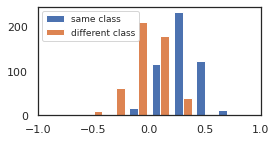

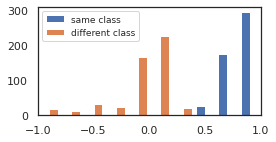

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style='white') 

plt.figure(figsize=(4, 2))
labels = ['same class', 'different class']
plt.hist([grad_sims_same, grad_sims_not_same], bins=10, range=(-1, 1), stacked=False, label=labels)
plt.xlim(-1, 1)
plt.legend(fontsize=9)
plt.show()

plt.figure(figsize=(4, 2))
labels = ['same class', 'different class']
plt.hist([res_sims_same, res_sims_not_same], bins=10, range=(-1, 1), stacked=False, label=labels)
plt.xlim(-1, 1)
plt.legend(fontsize=9)
plt.show()

## Figure 8

### MNIST with CNN

In [119]:
from cnn import CNN
import umap

saved_dir = os.path.join(os.environ['HOME'], 'research/interpret_gen/results/chainer_inf/models/mnist_merged_small')

with open(os.path.join(saved_dir, 'encoded_data.pkl'), 'rb') as fi:
    all_data = pickle.load(fi)
train, dev, test = all_data['train'], all_data['dev'], all_data['test']

with open(os.path.join(saved_dir, 'setting.json')) as fi:
    setting = json.load(fi)

with open(os.path.join(saved_dir, 'label.json')) as fi:
    label_dic = json.load(fi)

model_file = os.path.join(saved_dir, 'best_model.npz')

out_channels = [int(n) for n in setting['out_dims'].split(' ')]
ksizes = [int(n) for n in setting['filter_sizes'].split(' ')]
pool_sizes = [int(n) for n in setting['pool_sizes'].split(' ')]
model = CNN(
    input_channel=1,
    out_channels=out_channels,
    ksizes=ksizes,
    pool_sizes=pool_sizes,
    num_classes=2,
    out_dir=saved_dir
)

if gpu > -1:
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

serializers.load_npz(model_file, model)

/home/hanawa/.pyenv/versions/anaconda3-4.2.0/envs/py36/lib/python3.6/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [116]:
import get_convertor
hs = []
classes = []
merged_classes = []
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    test_iter = chainer.iterators.SerialIterator(test, batch_size=1, repeat=False, shuffle=False)
    for batch in test_iter:
        classes.append(str(batch[0][2]))
        merged_classes.append(str(batch[0][1]))
        x, y = get_convertor.mnist_convert(batch, model.device)
        h = model.get_all_h(x, y)[0]
        hs.append(h)
hs = np.vstack(hs)
classes = np.hstack(classes)
merged_classes = np.hstack(merged_classes)

cls_dic = {}
for cl, mcl in zip(classes, merged_classes):
    cls_dic[cl] = mcl

In [117]:
hs_0 = hs[merged_classes == '0'][:3000]
classes_0 = classes[merged_classes == '0'][:3000]
hs_1 = hs[merged_classes == '1'][:3000]
classes_1 = classes[merged_classes == '1'][:3000]

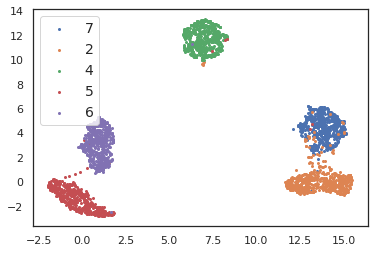

In [120]:
X_reduced = umap.UMAP().fit_transform(hs_0)
for label in cls_dic:
    if cls_dic[label] == '0':
        plt.scatter(X_reduced[classes_0 == label, 0], X_reduced[classes_0 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()

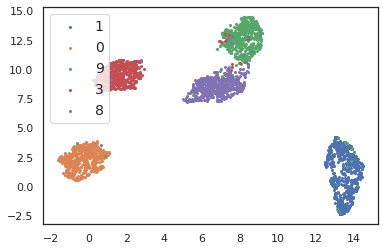

In [121]:
X_reduced_1 = umap.UMAP().fit_transform(hs_1)
for label in cls_dic:
    if cls_dic[label] == '1':
        plt.scatter(X_reduced_1[classes_1 == label, 0], X_reduced_1[classes_1 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()

### CIFAR10 with CNN

In [5]:
from cnn import CNN
import umap

saved_dir = os.path.join(os.environ['HOME'], 'research/interpret_gen/results/chainer_inf/models/cifar10_merged_3')

with open(os.path.join(saved_dir, 'encoded_data.pkl'), 'rb') as fi:
    all_data = pickle.load(fi)
train, dev, test = all_data['train'], all_data['dev'], all_data['test']

with open(os.path.join(saved_dir, 'setting.json')) as fi:
    setting = json.load(fi)

with open(os.path.join(saved_dir, 'label.json')) as fi:
    label_dic = json.load(fi)

model_file = os.path.join(saved_dir, 'best_model.npz')

out_channels = [int(n) for n in setting['out_dims'].split(' ')]
ksizes = [int(n) for n in setting['filter_sizes'].split(' ')]
pool_sizes = [int(n) for n in setting['pool_sizes'].split(' ')]
out_channels = [int(n) for n in setting['out_dims'].split(' ')]
ksizes = [int(n) for n in setting['filter_sizes'].split(' ')]
pool_sizes = [int(n) for n in setting['pool_sizes'].split(' ')]
model = CNN(
    input_channel=3,
    out_channels=out_channels,
    ksizes=ksizes,
    pool_sizes=pool_sizes,
    num_classes=2,
    out_dir=saved_dir
)

if gpu > -1:
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

serializers.load_npz(model_file, model)

/home/hanawa/.pyenv/versions/anaconda3-4.2.0/envs/py36/lib/python3.6/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [6]:
import get_convertor
hs = []
classes = []
merged_classes = []
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    test_iter = chainer.iterators.SerialIterator(test, batch_size=1, repeat=False, shuffle=False)
    for batch in test_iter:
        classes.append(str(batch[0][2]))
        merged_classes.append(str(batch[0][1]))
        x, y = get_convertor.cifar10_convert(batch, model.device)
        h = model.get_all_h(x, y)[0]
        hs.append(h)
hs = np.vstack(hs)
classes = np.hstack(classes)
merged_classes = np.hstack(merged_classes)

cls_dic = {}
for cl, mcl in zip(classes, merged_classes):
    cls_dic[cl] = mcl

In [7]:
hs_0 = hs[merged_classes == '0'][:3000]
classes_0 = classes[merged_classes == '0'][:3000]
hs_1 = hs[merged_classes == '1'][:3000]
classes_1 = classes[merged_classes == '1'][:3000]

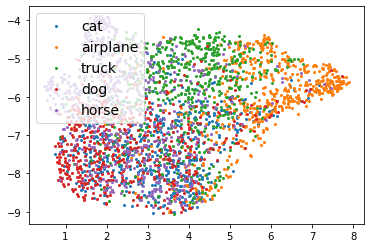

In [8]:
X_reduced = umap.UMAP().fit_transform(hs_0)
for label in cls_dic:
    if cls_dic[label] == '0':
        plt.scatter(X_reduced[classes_0 == label, 0], X_reduced[classes_0 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()

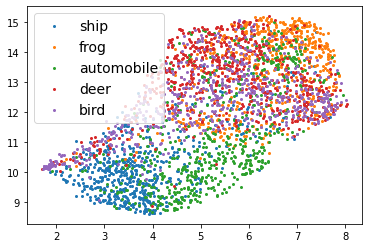

In [9]:
X_reduced_1 = umap.UMAP().fit_transform(hs_1)
for label in cls_dic:
    if cls_dic[label] == '1':
        plt.scatter(X_reduced_1[classes_1 == label, 0], X_reduced_1[classes_1 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()

### TREC with LSTM

In [10]:
from lstm import LSTM
import umap

saved_dir = os.path.join(os.environ['HOME'], 'research/interpret_gen/results/chainer_inf/models/trec_merged_small')

# json -> pkl
with open(os.path.join(saved_dir, 'encoded_data.json'), 'rb') as fi:
    all_data = pickle.load(fi)
train, dev, test = all_data['train'], all_data['dev'], all_data['test']

with open(os.path.join(saved_dir, 'setting.json')) as fi:
    setting = json.load(fi)

with open(os.path.join(saved_dir, 'label.json')) as fi:
    label_dic = json.load(fi)

model_file = os.path.join(saved_dir, 'best_model.npz')

with open(os.path.join(saved_dir, 'vocab.json')) as fi:
    vocab = json.load(fi)

model = LSTM(
    n_vocab=len(vocab),
    n_emb=setting['n_emb'],
    n_layers=setting['n_layers'],
    n_dim=setting['n_dim'],
    num_classes=2,
    dropout=0,
    out_dir=saved_dir
)

if gpu > -1:
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

serializers.load_npz(model_file, model)

In [11]:
import get_convertor
hs = []
classes = []
merged_classes = []
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    test_iter = chainer.iterators.SerialIterator(test, batch_size=1, repeat=False, shuffle=False)
    for batch in test_iter:
        classes.append(str(batch[0][2]))
        merged_classes.append(str(batch[0][1]))
        x, y = get_convertor.text_convert(batch, model.device)
        h = model.get_all_h(x, y)[0]
        hs.append(h)
hs = np.vstack(hs)
classes = np.hstack(classes)
merged_classes = np.hstack(merged_classes)

cls_dic = {}
for cl, mcl in zip(classes, merged_classes):
    cls_dic[cl] = mcl

In [12]:
hs_0 = hs[merged_classes == '0'][:3000]
classes_0 = classes[merged_classes == '0'][:3000]
hs_1 = hs[merged_classes == '1'][:3000]
classes_1 = classes[merged_classes == '1'][:3000]

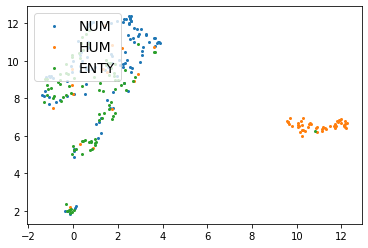

In [13]:
X_reduced = umap.UMAP().fit_transform(hs_0)
for label in cls_dic:
    if cls_dic[label] == '0':
        plt.scatter(X_reduced[classes_0 == label, 0], X_reduced[classes_0 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()

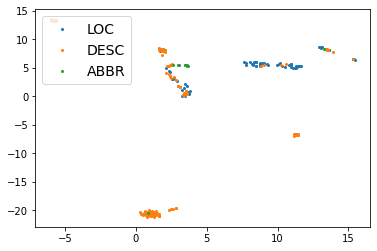

In [14]:
X_reduced_1 = umap.UMAP().fit_transform(hs_1)
for label in cls_dic:
    if cls_dic[label] == '1':
        plt.scatter(X_reduced_1[classes_1 == label, 0], X_reduced_1[classes_1 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()

### CF with LSTM

In [15]:
from cnn import CNN
import umap

saved_dir = os.path.join(os.environ['HOME'], 'research/interpret_gen/results/chainer_inf/models/cf_merged_small')

# json -> pkl
with open(os.path.join(saved_dir, 'encoded_data.json'), 'rb') as fi:
    all_data = pickle.load(fi)
train, dev, test = all_data['train'], all_data['dev'], all_data['test']

with open(os.path.join(saved_dir, 'setting.json')) as fi:
    setting = json.load(fi)

with open(os.path.join(saved_dir, 'label.json')) as fi:
    label_dic = json.load(fi)

model_file = os.path.join(saved_dir, 'best_model.npz')

with open(os.path.join(saved_dir, 'vocab.json')) as fi:
    vocab = json.load(fi)

model = LSTM(
    n_vocab=len(vocab),
    n_emb=setting['n_emb'],
    n_layers=setting['n_layers'],
    n_dim=setting['n_dim'],
    num_classes=2,
    dropout=0,
    out_dir=saved_dir
)

if gpu > -1:
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

serializers.load_npz(model_file, model)

In [16]:
import get_convertor
hs = []
classes = []
merged_classes = []
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    test_iter = chainer.iterators.SerialIterator(test, batch_size=1, repeat=False, shuffle=False)
    for batch in test_iter:
        classes.append(str(batch[0][2]))
        merged_classes.append(str(batch[0][1]))
        x, y = get_convertor.text_convert(batch, model.device)
        h = model.get_all_h(x, y)[0]
        hs.append(h)
hs = np.vstack(hs)
classes = np.hstack(classes)
merged_classes = np.hstack(merged_classes)

cls_dic = {}
for cl, mcl in zip(classes, merged_classes):
    cls_dic[cl] = mcl

In [17]:
hs_0 = hs[merged_classes == '0'][:3000]
classes_0 = classes[merged_classes == '0'][:3000]
hs_1 = hs[merged_classes == '1'][:3000]
classes_1 = classes[merged_classes == '1'][:3000]

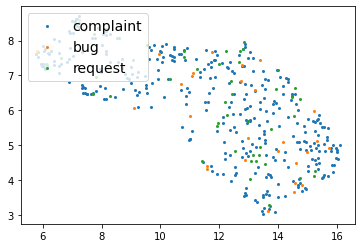

In [18]:
X_reduced = umap.UMAP().fit_transform(hs_0)
for label in cls_dic:
    if cls_dic[label] == '0':
        plt.scatter(X_reduced[classes_0 == label, 0], X_reduced[classes_0 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()

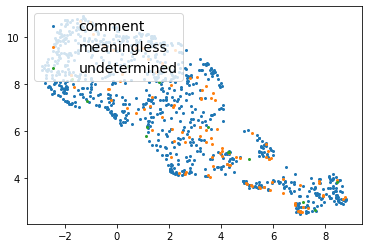

In [19]:
X_reduced_1 = umap.UMAP().fit_transform(hs_1)
for label in cls_dic:
    if cls_dic[label] == '1':
        plt.scatter(X_reduced_1[classes_1 == label, 0], X_reduced_1[classes_1 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()

### CIFAR10 with MobileNetV2

In [20]:
import umap
import torch
import sys
sys.path.append('./torch')
import mobilenetv2 as mobilenetv2

saved_dir = os.path.join(os.environ['HOME'], 'research/interpret_gen/results/torch_inf/cifar10_mobilenetv2_merged_3')

with open(os.path.join(saved_dir, 'label.json')) as fi:
    label_dic = {int(k): v for k, v in json.load(fi).items()}

data_params = {'path': 'data/cifar10_torchvision_merged', 'batch_size': 1}
train_loader, validation_loader, _ = mobilenetv2.make_dataloaders(data_params, merge=True, map_dic=label_dic)
train_loader_y, validation_loader_y, _ = mobilenetv2.make_dataloaders(data_params, merge=False)

data_params = {'path': 'data/cifar10_torchvision_merged', 'batch_size': 32}
train_loader_batch, validation_loader_batch, _ = mobilenetv2.make_dataloaders(data_params, merge=True, map_dic=label_dic)

data_params = {'path': 'data/cifar10_torchvision_merged', 'batch_size': 1}
train_loader_raw, validation_loader_raw, _ = mobilenetv2.make_dataloaders(data_params, raw=True, merge=True, map_dic=label_dic)

test = [d for d in validation_loader]
train = [d for d in train_loader]
test_raw = [d for d in validation_loader_raw]
train_raw = [d for d in train_loader_raw]
test_y = [d for d in validation_loader_y]
train_y = [d for d in train_loader_y]


if gpu > -1:
    device = 'cuda:{}'.format(gpu)
else:
    device = 'cpu'

model_path = os.path.join(os.environ['HOME'], 'research/interpret_gen/src/torch_inf/state_dicts_3/mobilenet_v2_merged.3.pt')
model = mobilenetv2.mobilenet_v2(pretrained=True, device=device, num_classes=2, model_path=model_path)
model.out_dir = saved_dir

model = model.to(device).eval()
model.device = device

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [21]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
hs = []
with torch.no_grad():
    for i, (image, label) in enumerate(tqdm(validation_loader)):
        image = image.to(model.device)
        test_feature = model.get_all_h(image)
        hs.append(test_feature)
hs = np.vstack(hs)
classes = np.array([str(class_names[int(d[1][0])]) for d in test_y])[:hs.shape[0]]
merged_classes = np.array([str(int(d[1][0])) for d in test])[:hs.shape[0]]

cls_dic = {}
for cl, mcl in zip(classes, merged_classes):
    cls_dic[cl] = mcl

100%|██████████| 10000/10000 [01:29<00:00, 112.22it/s]


In [25]:
hs_0 = hs[merged_classes == '0'][:3000]
classes_0 = classes[merged_classes == '0'][:3000]
hs_1 = hs[merged_classes == '1'][:3000]
classes_1 = classes[merged_classes == '1'][:3000]

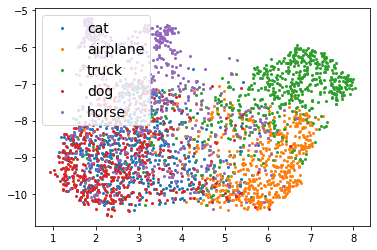

In [26]:
X_reduced = umap.UMAP().fit_transform(hs_0)
for label in cls_dic:
    if cls_dic[label] == '0':
        plt.scatter(X_reduced[classes_0 == label, 0], X_reduced[classes_0 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()

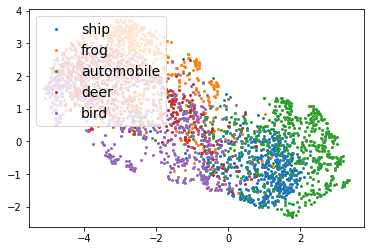

In [27]:
X_reduced_1 = umap.UMAP().fit_transform(hs_1)
for label in cls_dic:
    if cls_dic[label] == '1':
        plt.scatter(X_reduced_1[classes_1 == label, 0], X_reduced_1[classes_1 == label, 1], label=label, s=4)
plt.legend(loc='upper left', fontsize=14)
plt.show()